In [330]:
import numpy as np
import math
from filterpy.stats import plot_covariance_ellipse
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle
from scipy.stats import norm
from matplotlib import animation
import ffmpeg

In [331]:
def predict(X, P, dt):
    F = np.array([[1,-1*dt],[0,1]])
    X_HAT = F @ X
    P_HAT = F @ P @ F.T
    return (X_HAT,P_HAT)

In [332]:
def observe(X_HAT, P_HAT, Z):
    K = P_HAT @ H.T @ np.linalg.inv(H @ P_HAT @ H.T + R)
    X_NEW = X_HAT + K @ ( Z - H @ X_HAT )
    P_NEW = P_HAT - K @ H @ P_HAT
    return (X_NEW,P_NEW)

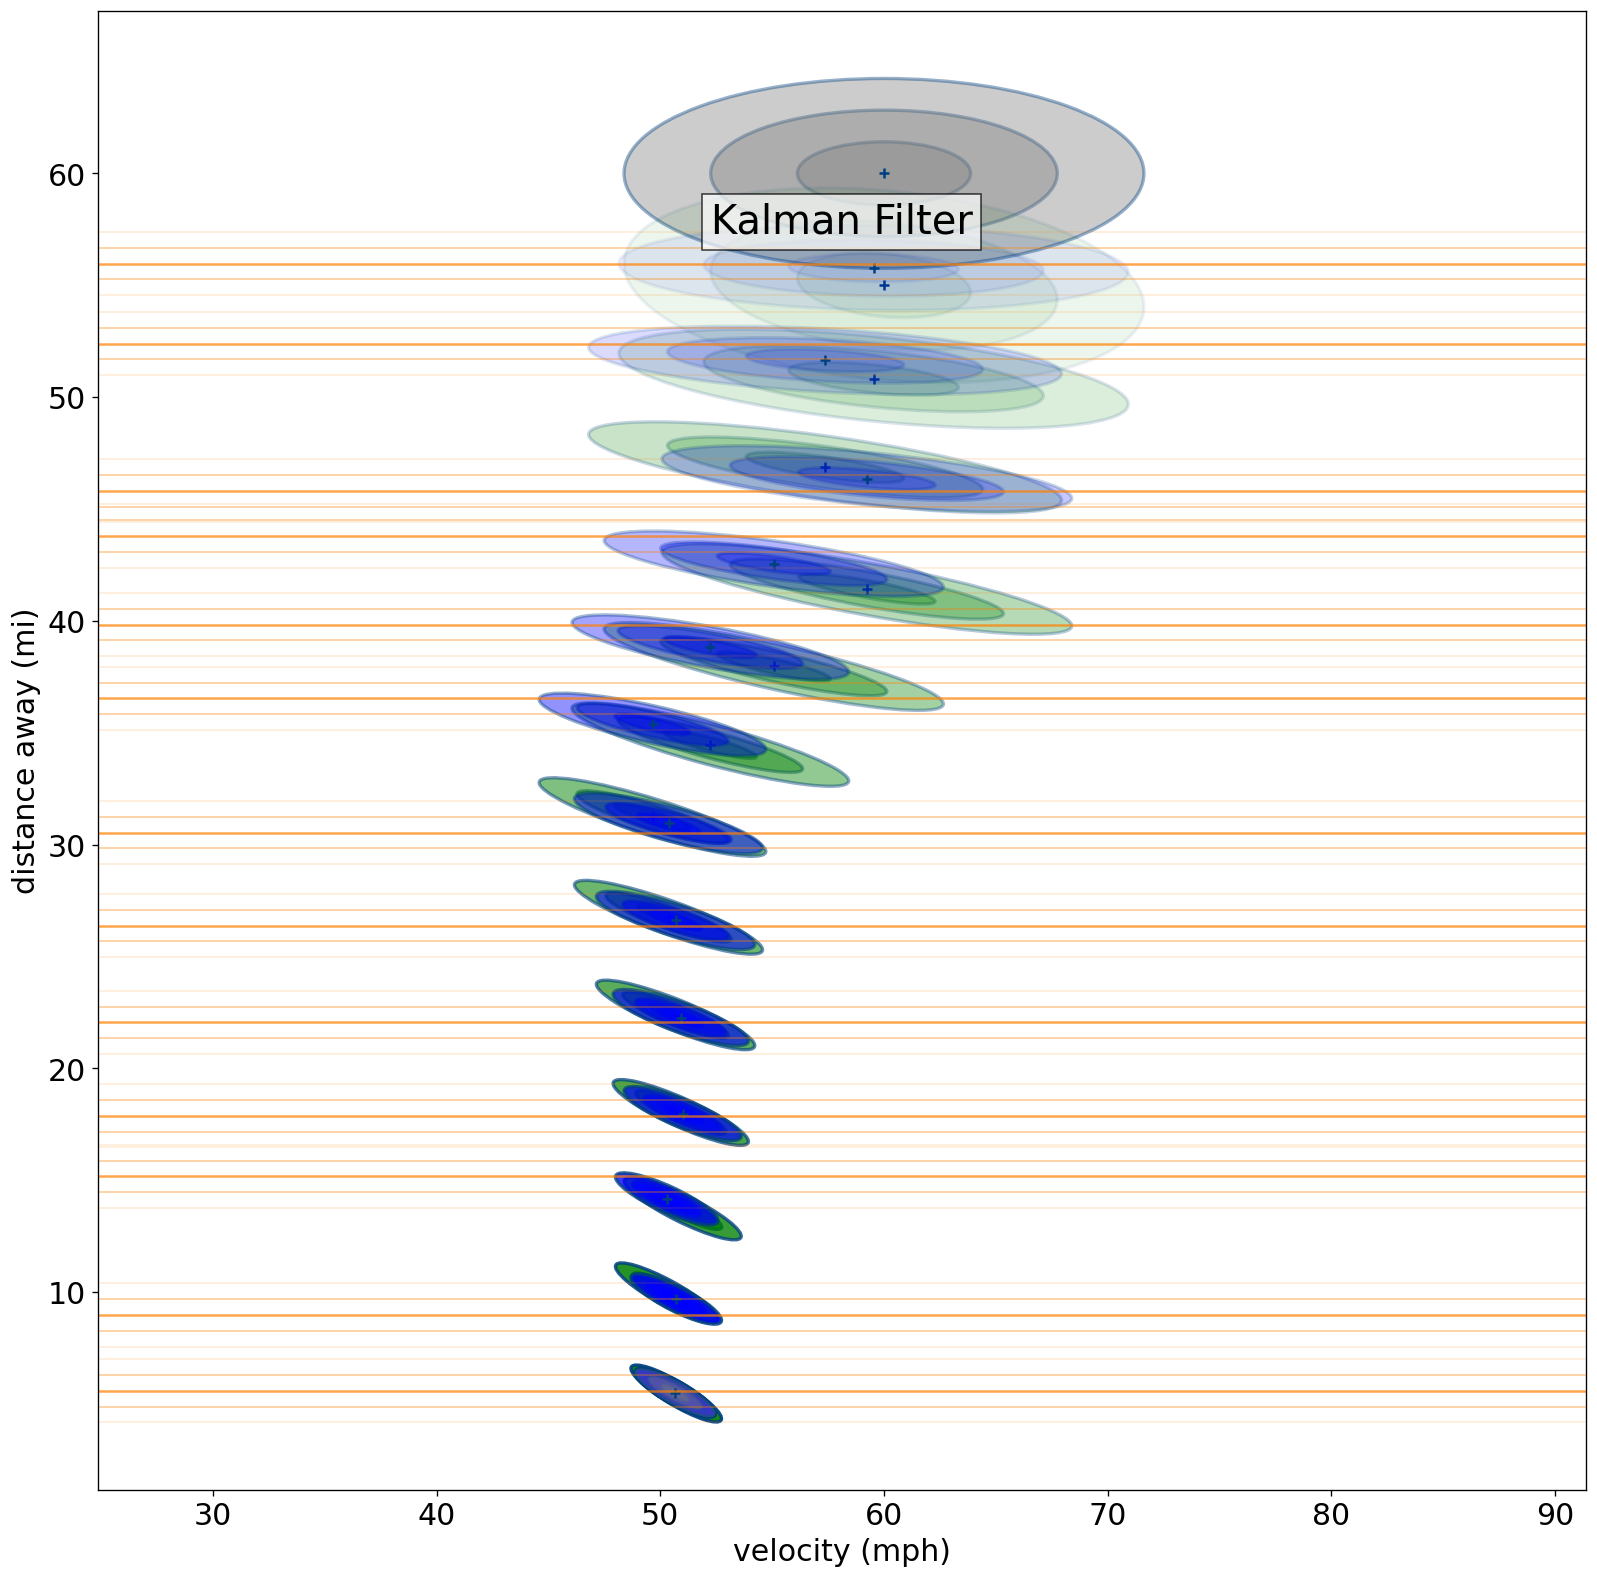

In [334]:
 ## PLOT SETUP
fig = figure(figsize=(16, 16), dpi=120)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
mpl.rcParams["font.size"] = 24
title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.7, 'pad':5}, transform=ax.transAxes, ha="center")
plt.xlabel('velocity (mph)')
plt.ylabel('distance away (mi)')

## KALMAN FILTER VARIABLE SETUP
X = np.array([[60],[60]]) # distance, velocity
P = np.array([[2,0],[0,15]])
Q = np.array([[0,0],[0,0]])
H = np.array([[1,0]])
R = np.array([.5])

X_HAT = None
P_HAT = None

## MEASUREMENTS -- distance between is hard coded in for loop below, i.e. .083333 for 1/12 of an hour
distances = [ 55.83,
    51.67,
    47.50,
    43.33,
    39.17,
    35.00,
    30.83,
    26.67,
    22.50,
    18.33,
    14.17,
    10.00,
    5.83,
    1.67]

measurements = []
for d in distances:
    #measurements.append(d) #use this line instead for 100% accurate measurements. Model will not consider them 100% accurate unless R is adjusted above, though.
    measurements.append( np.random.normal(d,math.sqrt(R[0]),1)[0] ) # draw a random value from gaussian around the real distance

def init():
    # initial plotting
    plot_covariance_ellipse((X[1][0], X[0][0]),  [[P[1][0], P[1][1]], [P[0][0], P[0][1]]], fc='gray', alpha=0.4, 
                        std=[1, 2, 3],
                        )
    title.set_text(f"Kalman Filter")

# animation function.  This is called based on animation needs, sequentially, 3 times for each kalman filter cycle. 
def animate(raw_i):
    global X,P,X_HAT,P_HAT
    i = raw_i // 3 # which cycle # are we actually at

    z = measurements[i]

    if raw_i % 3 == 0: # Predict
        X_HAT, P_HAT = predict(X, P, .08333)
        title.set_text(f"Round {i+1} - PREDICTION: {X_HAT[0][0]:.2f}mi. away at {X_HAT[1][0]:.2f}mph")
        plot_covariance_ellipse((X_HAT[1][0], X_HAT[0][0]),  [[P_HAT[1][0], P_HAT[1][1]], [P_HAT[0][0], P_HAT[0][1]]], fc='g', alpha=(1/len(measurements))*(i+1), 
                        std=[1, 2, 3],
                        )
    elif raw_i % 3 == 1: # Visualize measurement
        title.set_text(f"Round {i+1} - MEASUREMENT: Dist {z:.2f}")

        # # Simulating 1-d gaussian onto 2-d space...
        plt.axhline(y=(z-2*math.sqrt(R[0])), linewidth=1, color=(1., 0.5, 0., 0.15))
        plt.axhline(y=(z-math.sqrt(R[0])), linewidth=1, color=(1., 0.5, 0., 0.4))
        plt.axhline(y=z, color=(1., 0.5, 0., 0.7))
        plt.axhline(y=(z+math.sqrt(R[0])), linewidth=1, color=(1., 0.5, 0., 0.4))
        plt.axhline(y=(z+2*math.sqrt(R[0])), linewidth=1, color=(1., 0.5, 0., 0.15))

    else:
        # Update
        X, P = observe(X_HAT, P_HAT, z)
        title.set_text(f"Round {i+1} - UPDATE: Mean {X[0][0]:.2f}mi. away at {X[1][0]:.2f}mph")

        plot_covariance_ellipse((X[1][0], X[0][0]),  [[P[1][0], P[1][1]], [P[0][0], P[0][1]]], fc='b', alpha=(1/len(measurements))*(i+1), 
                            std=[1, 2, 3],
                            )

anim = animation.FuncAnimation(fig, animate,init_func=init, frames=(len(measurements)-1)*3, interval=1000)
writervideo = animation.FFMpegWriter(fps=1)
anim.save('kalman-demo-standard.gif', writer="imagemagick", fps=1)


